In [1]:
import pandas as pd
import numpy as np
import nltk

In [2]:
from nltk import word_tokenize

In [3]:
import string
def tokenizer_better(text):
    # tokenize the text by replacing punctuation and numbers with spaces and lowercase all words
    
    punc_list = string.punctuation+'0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.lower().translate(t)
    tokens = word_tokenize(text)
    return tokens

In [4]:
from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import auc
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def run(fold_n):
    df_train=pd.read_csv('/scratch/kh2383/Mortality/data/fold'+str(fold_n)+'/train.csv')
    #df_train = df_train[df_train.CATEGORY == 'Physician ']
    df_concat = df_train.groupby(['HADM_ID','Label']).TEXT.apply(' '.join).reset_index()

    df_val=pd.read_csv('/scratch/kh2383/Mortality/data/fold'+str(fold_n)+'/val.csv')
    #df_val = df_val[df_val.CATEGORY.isin(['Nursing', 'Nursing/other'])]
    df_concat_val = pd.DataFrame(df_val.groupby(['HADM_ID','Label']).TEXT.apply(' '.join)).reset_index()

    df_test=pd.read_csv('/scratch/kh2383/Mortality/data/test.csv')
    #df_test = df_test[df_test.CATEGORY.isin(['Nursing', 'Nursing/other'])]
    df_concat_test = pd.DataFrame(df_test.groupby(['HADM_ID','Label']).TEXT.apply(' '.join)).reset_index()

    from nltk.corpus import stopwords
    stop=list(stopwords.words('english'))
    from sklearn.feature_extraction.text import CountVectorizer
    vect = CountVectorizer(max_features = 3000, stop_words = stop, tokenizer = tokenizer_better)
    vect.fit(df_concat['TEXT'].values)

    X_train_tf = vect.transform(df_concat.TEXT.values)
    X_valid_tf = vect.transform(df_concat_val.TEXT.values)
    X_test_tf = vect.transform(df_concat_test.TEXT.values)

    y_train = df_concat.Label
    y_valid = df_concat_val.Label
    y_test = df_concat_test.Label

    params = {'n_estimators': 500,
              'learning_rate': 0.01, 'loss': 'ls'}
    clf = GradientBoostingRegressor(**params)
    clf.fit(X_train_tf, y_train)  
    
    feature_importance = clf.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    d = dict(zip(np.asarray(vect.get_feature_names()), feature_importance))

    np.save("../result/gb_nurse_phy_feature_importance_fold"+str(fold_n)+".npy", d)
    
    model = clf

    y_train_preds = model.predict(X_train_tf)
    y_valid_preds = model.predict(X_valid_tf)
    y_test_preds = model.predict(X_test_tf)
    np.save('../result/gb_nurses_phy_logits_fold'+str(fold_n)+'.npy', y_test_preds)

    fpr, tpr, thresholds = roc_curve(y_valid, y_valid_preds)

    precision = tpr / (tpr + fpr)

    f1 = 2 * precision * tpr / (tpr + precision + 0.00001)

    thred_optim = thresholds[5:][np.argmax(f1[5:])]

    print("optimal threshold: " + str(thred_optim))

    y_pred_s = [1 if i else 0 for i in (y_test_preds >= thred_optim)]
    #print (sum(y_pred_s == y_valid) / len(y_valid))
    fpr, tpr, thresholds = roc_curve(y_test, y_test_preds)
    auc_k = auc(fpr, tpr)
    print("AUROC:" + str(auc_k))
    print("AUPRC: "+ str(average_precision_score(y_test, y_test_preds)))

    cm1 = confusion_matrix(y_test, y_pred_s)
    print('Confusion Matrix : \n', cm1)

    total1=sum(sum(cm1))
    #####from confusion matrix calculate accuracy
    accuracy1=(cm1[0,0]+cm1[1,1])/total1
    print ('Accuracy : ', accuracy1)

    sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    print('Sensitivity : ', sensitivity1 )

    specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    print('Specificity : ', specificity1)

    #print(classification_report(y_test, y_pred_s, labels = [0,1]))
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='Test (area = {:.3f})'.format(auc_k))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

/home/kh2383/pytorch-gpu/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.311683201129
AUROC:0.835511686639
AUPRC: 0.739324162039
Confusion Matrix : 
 [[284 125]
 [ 39 204]]
Accuracy :  0.748466257669
Sensitivity :  0.694376528117
Specificity :  0.83950617284


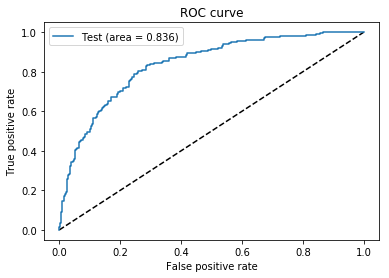

optimal threshold: 0.325194347629
AUROC:0.835863845372
AUPRC: 0.740475763405
Confusion Matrix : 
 [[286 123]
 [ 43 200]]
Accuracy :  0.745398773006
Sensitivity :  0.699266503667
Specificity :  0.82304526749


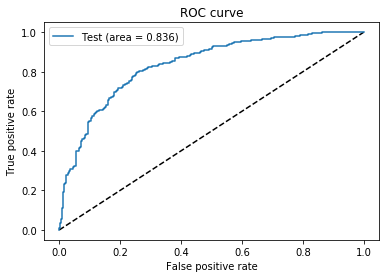

optimal threshold: 0.28488756106
AUROC:0.833680461227
AUPRC: 0.733562821766
Confusion Matrix : 
 [[266 143]
 [ 36 207]]
Accuracy :  0.725460122699
Sensitivity :  0.650366748166
Specificity :  0.851851851852


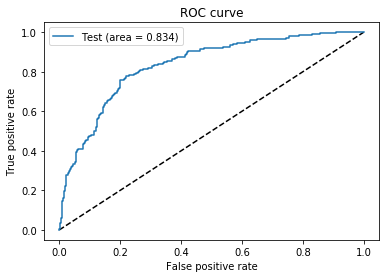

optimal threshold: 0.302454232501
AUROC:0.838842102086
AUPRC: 0.74675430438
Confusion Matrix : 
 [[284 125]
 [ 36 207]]
Accuracy :  0.753067484663
Sensitivity :  0.694376528117
Specificity :  0.851851851852


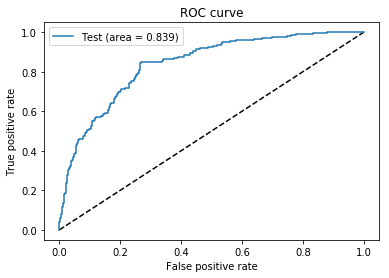

optimal threshold: 0.334168319216
AUROC:0.837876180989
AUPRC: 0.741470440869
Confusion Matrix : 
 [[298 111]
 [ 48 195]]
Accuracy :  0.756134969325
Sensitivity :  0.728606356968
Specificity :  0.802469135802


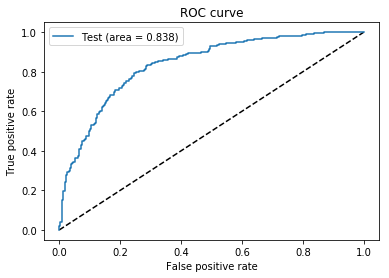

In [8]:
for i in range(1,6):
    run(i)